<style>
div.text_cell_render {
font-family: "Times New Roman", serif;
...
}
</style>

<h1>Auto-encoders cho Phát hiện xâm nhập mạng - HOMEWORK</h1>
<p><h2>Nội dung:</h2></p>
<h3>
<ol>
<li>Giới thiệu intrusive data</li>
<li>Tiền xử lý dữ liệu</li>
<li>Định nghĩa Autoencoder</li>
<li>Huấn luyện mô hình</li>
<li>Một số kết quả</li>   
</ol>
</h3>

<h3> * Làm bài thực hành Homework 1 và 2</h3>

<h1>I. Giới thiệu Instrusion Detection Dataset</h1>

Hệ thống phát hiện xâm nhập bảo vệ mạng máy tính từ những unauthorized users, bao gồm cả users từ bên trong mạng. Phát hiện xâm nhập dựa trên học máy là nhiệm vụ xây dựng mô hình dự đoán (predictive model) hay phân lớp (classifiers) có thê phân biệt được những kết nối xấu (bad connections), gọi là xâm nhập (intrusions) hay tấn công (attacks) và những kết nối tốt (good connections).

<h2>1. KDD Cup 1999 Dataset</h2>

Trong KDD Cup'99 dataset: một kết nối là một chuổi gói tin TCP bắt đầu và kết thúc ở những khoảng thời gian xác định giữa các luồng dữ liệu đi và đến từ một địa chỉ IP nguồn tới một địa chỉ IP đích theo một số giao thức xác định. Mỗi kết nối được gán nhãn là bình thường (normal) hoặc một tấn công, với một kiểu tấn công cụ thể. Mỗi bản ghi kết nối bao gồm 100 bytes.
 Các kiểu tấn công thuộc 1 trong 4 nhóm sau:
1.	DoS: Denial-of-Service, ví dụ: SYN FLOOD;
2.	R2L:  unauthorized access from a remote machine, ví dụ: guessing password;
3.	U2R: unauthorized access to local superuser (root) privileges, ví dụ: buffer overflow attacks;
4.	Probing: surveillance and other probing, ví dụ: port scanning.

Chú ý rằng tập dữ liệu đánh giá (test data) thì không lấy từ chung phân bố xác suất như tập huấn luyện (training data). Nó gồm cả những kiểu tấn công mới không có trong tập huấn luyện. Tập huấn luyện bao gồm 24 loại tấn công, trong khi tập đánh giá có thêm 14 loại tấn công mới. <p>Mô ta chi tiết về tập KDD Cup’99 xem tại link <a href="http://kdd.ics.uci.edu/databases/kddcup99/task.html">này</a>.</p>

<h3>Phân bố dữ liệu trong KDD Cup'99</h3>
<img src="table-kdd.png">


<h2>2. NSL-KDD Dataset</h2>

NSL-KDD là một một version of KDD Cup'99 dataset nhằm khắc phục một số nhược điểm của KDD Cup'99 dataset. Một số ưu điêm của NSL-KDD so với KDD Cup’99 dataset: 
1. Đã loại bỏ những bản ghi trùng lặp trong tập huấn luyện và tập đánh giá của KDD Cup’99
2. Tăng tỉ lệ số kết nối khó phân lớp so với số kết nối dễ phân lớp
3. Số lượng kết nối trong tập huấn luyện và đánh giá hợp lý. Việc này thuận tiện cho thiết kết và so sánh kết quả thí nghiệm bởi vì chúng ta có thể chạy thí nghiệm trên toàn bộ tập huấn luyện mà không phải lấy mẫu một tập nhỏ. 


<h3>Phân bố dữ liệu trong NSL-KDD</h3>
<img src="table-nsl99.png">

Tham khao:

Bhattacharyya, Dhruba Kumar, and Jugal Kumar Kalita. Network anomaly detection: A machine learning perspective. Chapman and Hall/CRC, 2013.

<h1>II. Tiền xử lý dữ liệu NSL-KDD</h1>

In [1]:
import pandas
import pandas as pd
import numpy as np
import sys
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


<h2>1. Đọc dữ liệu NSL-KDD</h2>

In [3]:
# We add the column names to the dataset
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", 
             "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
             "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
             "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
             "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
             "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate","dst_host_count", 
             "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
             "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
             "dst_host_srv_serror_rate", "dst_host_rerror_rate","dst_host_srv_rerror_rate", "label"]


# We have removed the difficulty score from KDDTrain+.csv & KDDTest+.csv
train_set = pd.read_csv("KDDTrain+.csv", header=None, names = col_names)
test_set  = pd.read_csv("KDDTest+.csv",  header=None, names = col_names)

# Show the size and dimensions of the dataset
print('Training set shape:',train_set.shape)
print('Testing set shape: ',test_set.shape)

Training set shape: (125973, 42)
Testing set shape:  (22544, 42)


In [4]:
train_set.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
5,0,tcp,private,REJ,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune
6,0,tcp,private,S0,0,0,0,0,0,0,...,9,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
7,0,tcp,private,S0,0,0,0,0,0,0,...,15,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune
8,0,tcp,remote_job,S0,0,0,0,0,0,0,...,23,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
9,0,tcp,private,S0,0,0,0,0,0,0,...,13,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune


<h2>2. Phân bố của dữ liệu<h2>

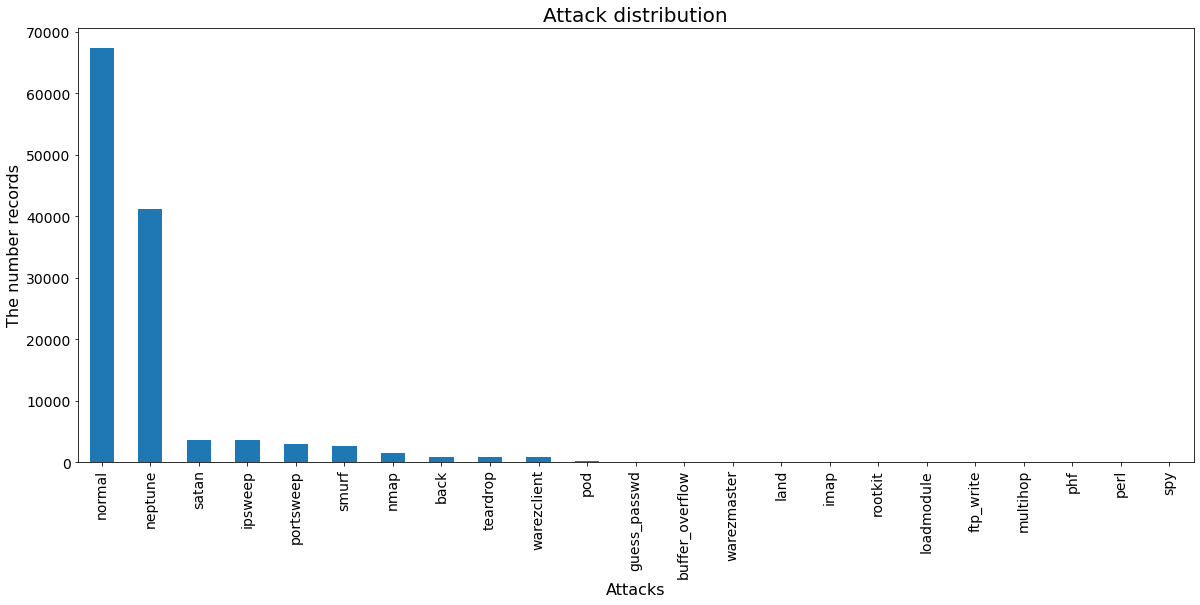

In [5]:
fre_label      = train_set.groupby('label').size()
fre_label_sort = fre_label.sort_values(ascending=False)

plt.subplots(figsize = (20,8))
plt.clf()
fre_label_sort.plot(kind='bar')

plt.xlabel("Attacks", fontsize = 16)
plt.ylabel("The number records", fontsize = 16)
plt.title("Attack distribution", fontsize = 20)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14, rotation=0)

plt.show()

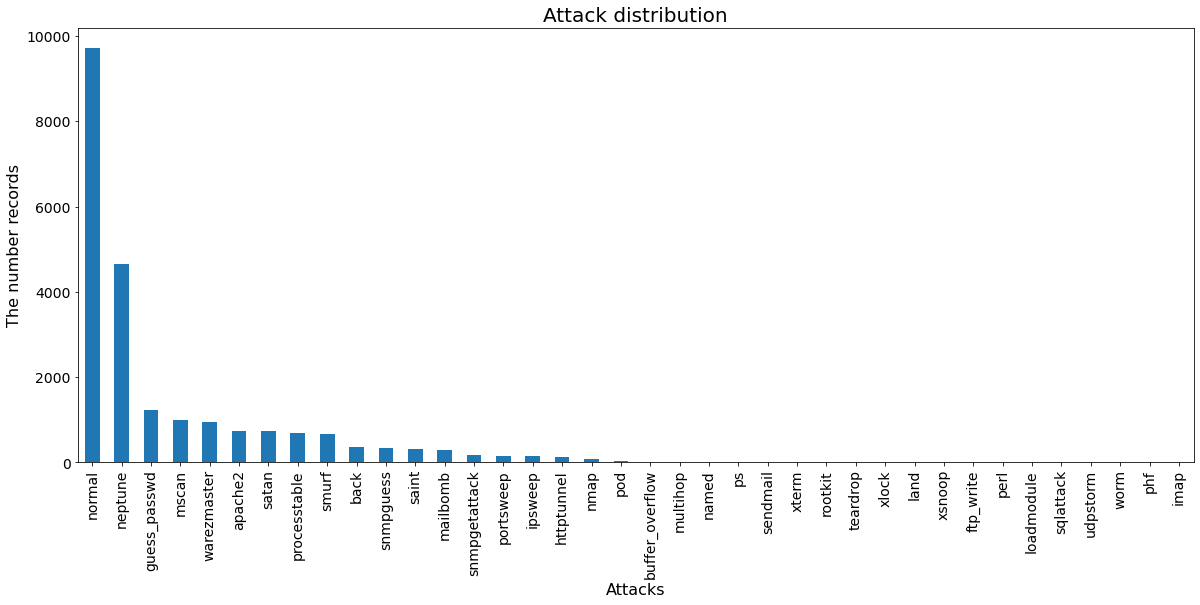

In [6]:
sizes = test_set.groupby('label').size()
d = sizes.sort_values(ascending=False)

plt.subplots(figsize = (20,8))
plt.clf()
d.plot(kind='bar')

plt.xlabel("Attacks", fontsize = 16)
plt.ylabel("The number records", fontsize = 16)
plt.title("Attack distribution", fontsize = 20)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14, rotation=0)

plt.show()

<h2>3. Xác định Categorical Features</h2>

In [7]:
# Identify categorical features in Train_set
for col in train_set.columns:
    if train_set[col].dtypes == 'object' :
        unique_cat = len(train_set[col].unique())
        print("'{col_name}': {unique_cat} categories".format(col_name=col, unique_cat=unique_cat))  

'protocol_type': 3 categories
'service': 70 categories
'flag': 11 categories
'label': 23 categories


In [8]:
# Identify categorical features in Test_set
for col_name in test_set.columns:
    if test_set[col_name].dtypes == 'object' :
        unique_cat = len(test_set[col_name].unique())
        print("'{col_name}': {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

'protocol_type': 3 categories
'service': 64 categories
'flag': 11 categories
'label': 38 categories


In [9]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, MaxAbsScaler

# Make a list of categorical columns
categorical_columns=['protocol_type', 'service', 'flag'] 

 # Get the categorical values into a 2D numpy array
d_train_cat = train_set[categorical_columns]
d_test_cat   = test_set[categorical_columns]

d_train_cat.head(5)

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


In [10]:
d_test_cat.head(5)

,protocol_type,service,flag
0,tcp,private,REJ
1,tcp,private,REJ
2,tcp,ftp_data,SF
3,icmp,eco_i,SF
4,tcp,telnet,RSTO


### Các features này cần được convert sang số thực trước khi đưa vào mô hình. Có nhiều kỹ thuật convert, trong đó On-hot-encoding được cho là tốt nhất vì đảm bảo được ngữ nghĩa của dữ liệu 

In [11]:
# protocol type
unique_protocol=sorted(train_set.protocol_type.unique())
# service
unique_service=sorted(train_set.service.unique())
# flag
unique_flag=sorted(train_set.flag.unique())

print("\n", unique_protocol)
print("\n", unique_service)
print("\n", unique_flag)


# protocol type
unique_protocol_1=sorted(test_set.protocol_type.unique())
# service
unique_service_1=sorted(test_set.service.unique())
# flag
unique_flag_1=sorted(test_set.flag.unique())
print("\n", unique_protocol_1)
print("\n", unique_service_1)
print("\n", unique_flag_1)


# serive different
for x in unique_service_1:
    if x not in unique_service:
        unique_service +=  x          




 ['icmp', 'tcp', 'udp']

 ['IRC', 'X11', 'Z39_50', 'aol', 'auth', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp', 'ftp_data', 'gopher', 'harvest', 'hostnames', 'http', 'http_2784', 'http_443', 'http_8001', 'imap4', 'iso_tsap', 'klogin', 'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns', 'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u', 'other', 'pm_dump', 'pop_2', 'pop_3', 'printer', 'private', 'red_i', 'remote_job', 'rje', 'shell', 'smtp', 'sql_net', 'ssh', 'sunrpc', 'supdup', 'systat', 'telnet', 'tftp_u', 'tim_i', 'time', 'urh_i', 'urp_i', 'uucp', 'uucp_path', 'vmnet', 'whois']

 ['OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH']

 ['icmp', 'tcp', 'udp']

 ['IRC', 'X11', 'Z39_50', 'auth', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp', 'ftp_data', 'g

<h2>4. One-hot-encoding</h2>
<h3>Homework 1</h3>
Bài thực hành, dùng kỹ thuật One-hot-encoding để convert categorical features sang dạng numerical features
    

In [13]:
from sklearn.preprocessing import OneHotEncoder
#################################### YOUR CODE HERE #############################
"""
Convert các trường protocol, service và flat sang dạng số:
    + xác định tập giá trị categorical features
    + Tìm tập giá trị duy nhất
    + Dùng One-hot-encoding trong Scikitlearn để chuyển đổi sang dạng số
"""

categorical_features = [unique_protocol, unique_service, unique_flag]
myEncoder = OneHotEncoder(handle_unknown='ignore')
train_onehot = pd.DataFrame(myEncoder.fit_transform(d_train_cat).toarray(),
                         columns=myEncoder.get_feature_names(categorical_columns), dtype=int)
test_onehot = pd.DataFrame(myEncoder.fit_transform(d_test_cat).toarray(),
                         columns=myEncoder.get_feature_names(categorical_columns), dtype=int)

#################################################################################

In [14]:
train_onehot

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
125969,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
125970,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
125971,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [15]:
test_onehot

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
22540,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
22541,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
22542,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Các kiểu tấn công thuộc và 4 nhóm tấn công mạng

In [16]:
DoS   = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop','apache2', 'mailbomb', 'processtable','udpstorm'] 
        # 4 new attacks in testing dataset
                           
R2L   = ['ftp_write','guess_passwd','imap','multihop','phf','spy','warezclient','warezmaster',\
                     'httptunnel','named', 'sendmail','snmpgetattack','snmpguess', 'worm', 'xlock', 'xsnoop'] 
        # 8 new attacks in testing dataset
                             
U2R   = ['buffer_overflow','loadmodule','perl','rootkit','xterm', 'ps', 'sqlattack']  
        # 3 new attacks in testing dataset

Probe = ['ipsweep', 'nmap', 'portsweep', 'satan','mscan', 'saint'] 
        # 2 new attacks in testing dataset

<h1>II. Độ đo đánh giá mô hình</h1>

In [17]:
#Function to compute The Area Under ROC Curve
def compute_AUC(recon_X, X, Y):
    from sklearn.metrics import roc_curve, auc
    recon_errors = ((recon_X - X)**2).mean(1)
    
    predictions = -recon_errors
    FPR, TPR, thresholds = roc_curve(Y, predictions)
    auc = auc(FPR, TPR)
    return FPR, TPR, auc

In [18]:
#Draw ROC 
def Plotting_AUC(FPR, TPR, auc):
    plt.figure(figsize=(6,6))
    plt.title('ROC curves', fontsize=16)
    plt.plot(FPR, TPR, 'g-^'  , label='AE      (AUC = %0.3f)'% auc, markevery = 150 , markersize = 6)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.show()

In [19]:
#Draw reconstruction errors and AUC during training process
def Plotting_RE_AUC(data):
    x  = data[:,0]
    re = data[:,1]
    auc = data[:,2]
    
    #The first figure for Reconstruction Errors
    plt.figure(figsize=(6,3))
    plt.title('Reconstruction Error', fontsize=16)

    plt.xlim([0.0, max(x) + 1.0])
    plt.ylim([0.0,0.05])

    plt.plot(x, re,  'b', label = 'Recon error')

    plt.legend(loc='upper right')
    plt.ylabel('Reconstruction Errors ', fontsize=14)
    plt.xlabel('Epochs', fontsize=14)
    plt.show()
    
    
    #The second figure for AUC
    plt.figure(figsize=(6,3))
    plt.title('The Area Under Curve', fontsize=16)

    plt.xlim([0.0, max(x) + 1.0])
    plt.ylim([0.5,1.0])

    plt.plot(x, auc,  'r', label = 'AUC')

    plt.legend(loc='lower right')
    plt.ylabel('AUC', fontsize=14)
    plt.xlabel('Epochs', fontsize=14)
    plt.show()
    

<h2>* AUC</h2>
   
- ROC: Receiver Operating Characteristics 

- AUC: Area Under The Curve
- Trong học một lớp cho phát hiện xâm nhập mạng, dữ liệu bình thường (normal data) được dùng để build mô hình. Chúng ta giải sử dữ liệu xâm nhập (anomalies) không có hoặc khan hiếm trong quá trình huấn luyện. Vì vậy, chúng ta không dùng dữ liệu xâm nhập để huấn luyện và chọn tham số. Do đó, AUC là một độ đo rất tốt và phù hợp cho trường hợp này, hơn nữa AUC là độ tốt hơn các độ đo như Accuracy cho các mô hình phân lớp nói chung.

<h3>Accuracy</h3>
<img src="confusion_matrix.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 100px;" />

<h3>AUC</h3>
<img src="AUC1.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 100px;" />


<img src="AUC2.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 100px;"
     height = "400"
     width = "350"/>     

<h3> Moving threshold</h3>

<img src="AUC_Threshold.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" /> 

<h1>III. Auto-encoder cho phát hiện bất thường</h1>

<h2>1. Tải dữ liệu</h2>

In [20]:
train_data = np.genfromtxt('NSLKDD_train.csv', dtype=np.float32, delimiter=',')
test_data  = np.genfromtxt('NSLKDD_test.csv', dtype=np.float32, delimiter=',')

<h2>2. Dữ liệu huấn luyện và đánh giá</h2>

In [21]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.metrics import roc_curve, auc

In [22]:
train_Y = train_data[:,-1]                #Select label column
train_X = train_data[train_Y == 0]        #Select only normal data for training  
train_X = train_X[:,0:-1]                 #Remove label column

np.random.shuffle(train_X)
train_X = train_X[:6734]                  #Sample 10% connections for training 

######################################
test_Y = test_data[:,-1]                  #Select label column  
test_X = test_data[:,0:-1]                #Select data except label column

test_X0 = test_X[test_Y == 0]             #Normal test
test_X1 = test_X[test_Y > 0]              #Anomaly test

test_X = np.concatenate((test_X0, test_X1))

test_y0 = np.full((len(test_X0)), True, dtype=bool)
test_y1 = np.full((len(test_X1)), False,  dtype=bool)
test_y =  np.concatenate((test_y0, test_y1))

#create binary label (1 for normal, 0 for anomaly) for compute AUC later
test_Y = (test_y).astype(np.int)

#Normalize data to [0, 1]
scaler = MinMaxScaler()
scaler.fit(train_X)
train_X = scaler.transform(train_X)
test_X  = scaler.transform(test_X)

print("Normal training data: ", train_X.shape[0]) 
print("Normal testing data:  ", test_X0.shape[0])
print("Anomaly testing data: ", test_X1.shape[0])

Normal training data:  6734
Normal testing data:   9711
Anomaly testing data:  12833


<h2>3. Tham số mô hình ( Hyperparameters)</h2>

   - $epochs$: số vòng lặp cho đến khi kết thúc huấn luyện mạng hoặc bắt đầu overfitting
   - $batch\_size$: kích thước lớn nhất mà bộ nhớ của máy tính có thể đáp ứng. Đa số chọn các kích thước phổ biến
   - $learning\_rate$: hệ số tốc độ cập nhật trọng số
   - $Hidden\_sizes$: Kích thức các lớp ẩn

In [23]:
num_input    = train_data[:,0:-1].shape[1]  # Số features đầu vào
print("Number of inputs: ", num_input)
num_hidden_1 = 50                           # layer thứ nhất với 40 neurons
num_hidden_2 = 10                           # layer thứ hai với 10 neurons

learning_rate = 0.01
epochs        = 500
batch_size    = 100

display_step = 10

Number of inputs:  122


<h2>4. Khai báo trọng số mô hình Weights va biases </h2>

In [24]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random.normal(shape=size, stddev=xavier_stddev)

In [25]:
weights = {
    'encoder_h1': tf.Variable(xavier_init([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(xavier_init([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(xavier_init([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(xavier_init([num_hidden_1, num_input]))
}

biases = {
    'encoder_b1': tf.Variable(tf.zeros(shape=[num_hidden_1])),
    'encoder_b2': tf.Variable(tf.zeros(shape=[num_hidden_2])),  
    'decoder_b1': tf.Variable(tf.zeros(shape=[num_hidden_1])),
    'decoder_b2': tf.Variable(tf.zeros(shape=[num_input]))
}

<h2>5. Định nghĩa Encoder và Decoder</h2>

In [26]:
def encoder(x):
    # Encoder Hidden layer with sigmoid activation
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    
    # Encoder Hidden layer with sigmoid activation
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    
    return layer_2


def decoder(x):
    # Decoder Hidden layer with sigmoid activation 
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    
    # Decoder Hidden layer with sigmoid activation
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))

    return layer_2

<h2>6. Xây dựng mô hình</h2>

In [27]:
# Đặt đầu vào cho graph
X = tf.placeholder("float", [None, num_input])

#Construct model
Z  = encoder(X)
Y  = decoder(Z)

# reconstruction input
y_pred = Y
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

<h2>7. Huấn luyện và kiểm thử mô hình</h2>

Step   0: Loss: 0.035613 AUC: 0.9339
Step  10: Loss: 0.007698 AUC: 0.9557
Step  20: Loss: 0.005419 AUC: 0.9524
Step  30: Loss: 0.003281 AUC: 0.9532
Step  40: Loss: 0.002204 AUC: 0.9560
Step  50: Loss: 0.001310 AUC: 0.9541
Step  60: Loss: 0.001046 AUC: 0.9558
Step  70: Loss: 0.000695 AUC: 0.9557
Step  80: Loss: 0.000703 AUC: 0.9564
Step  90: Loss: 0.000479 AUC: 0.9573
Step 100: Loss: 0.000367 AUC: 0.9574
Step 110: Loss: 0.000372 AUC: 0.9574
Step 120: Loss: 0.000413 AUC: 0.9589
Step 130: Loss: 0.000309 AUC: 0.9595
Step 140: Loss: 0.000318 AUC: 0.9562
Step 150: Loss: 0.000273 AUC: 0.9579
Step 160: Loss: 0.000237 AUC: 0.9566
Step 170: Loss: 0.000994 AUC: 0.9622
Step 180: Loss: 0.000188 AUC: 0.9601
Step 190: Loss: 0.000195 AUC: 0.9594
Step 200: Loss: 0.000173 AUC: 0.9602
Step 210: Loss: 0.000216 AUC: 0.9601
Step 220: Loss: 0.000174 AUC: 0.9600
Step 230: Loss: 0.000255 AUC: 0.9631
Step 240: Loss: 0.000178 AUC: 0.9626
Step 250: Loss: 0.000111 AUC: 0.9643
Step 260: Loss: 0.000156 AUC: 0.9639
S

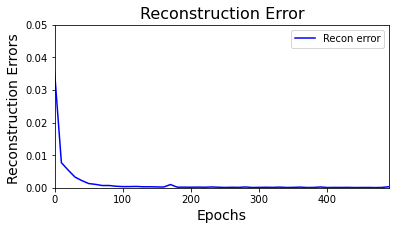

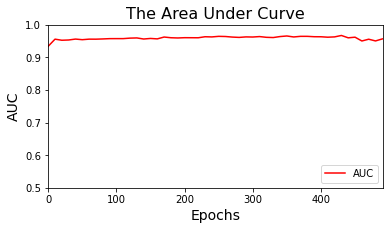

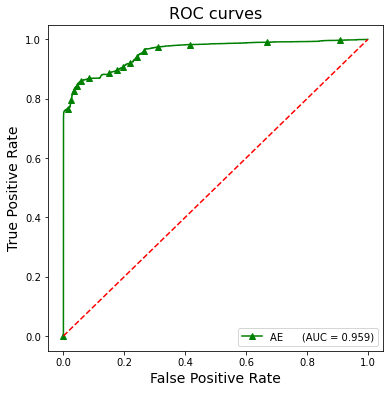

In [28]:
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)
num_batch = int(train_X.shape[0]/batch_size)

# Training
monitor = np.empty([0,3])    #Define a array to store training errors, and AUC during training process
for i in range(epochs):
    re_batch = 0
    for i_batch in range(num_batch):
        batch_x = train_X[i_batch:i_batch+1] 
        _,l = sess.run([optimizer, loss], feed_dict={X: batch_x})
        re_batch = re_batch + l
        
    # Display logs per step
    if i % display_step == 0:
        recon_X   = sess.run(Y, feed_dict={X:test_X})
        _, _, auc = compute_AUC(recon_X, test_X, test_Y)
        re = re_batch/num_batch
        monitor = np.append(monitor,[i, re, auc])
        print('Step %3.0f: Loss: %f AUC: %0.4f' % (i, re, auc))

monitor = np.reshape(monitor, (-1,3))
#Draw RE and AUC during training process
Plotting_RE_AUC(monitor)

#Compute and draw ROC curve after training

recon_X   = sess.run(Y, feed_dict={X:test_X})
FPR, TPR, auc = compute_AUC(recon_X, test_X, test_Y)
Plotting_AUC(FPR, TPR, auc)

<h2>8. Autoencoder vs One-class SVM</h2>

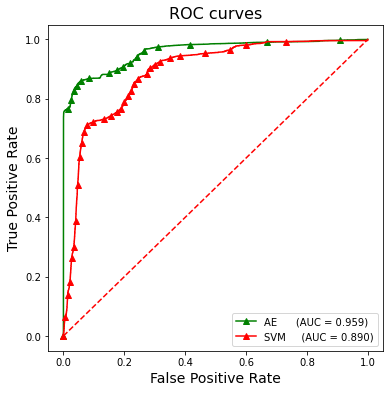

In [29]:
from sklearn import svm
from sklearn.metrics import roc_curve, auc
gamma  = 1.0/train_X.shape[1]
clf_svm = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=gamma)
clf_svm.fit(train_X)

predictions_svm  = clf_svm.decision_function(test_X)
FPR_svm, TPR_svm, thresholds_svm = roc_curve(test_Y, predictions_svm)
auc_svm = auc(FPR_svm, TPR_svm)



recon_X   = sess.run(Y, feed_dict={X:test_X})
FPR, TPR, auc = compute_AUC(recon_X, test_X, test_Y)

plt.figure(figsize=(6,6))
plt.title('ROC curves', fontsize=16)
plt.plot(FPR, TPR,         'g-^'  , label='AE      (AUC = %0.3f)'% auc, markevery = 150 , markersize = 6)
plt.plot(FPR_svm, TPR_svm, 'r-^'  , label='SVM     (AUC = %0.3f)'% auc_svm, markevery = 150 , markersize = 6)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.show()

<h1>IV. Denoising Auto-encoder</h1>

<h3>1. Gaussian noise</h3>

In [30]:
def gaussian_additive_noise(x, std):
    return x + tf.random_normal(shape=tf.shape(x), dtype=tf.float32, mean=0.0, stddev=std)

<h3>Homework 2</h3>
Tạo dữ liệu noise bằng cách, ngẫu nhiên drop 10%, 20% các giá trị của từng mẫu dữ liệu về giá trị 0

In [31]:
################################# YOUR CODE HERE ###############################
def gaussian_multi_noise(x, percent):
    x_noise = (np.random.random(len(x)) > percent)
    return x*x_noise
################################################################################

In [32]:
weights = {
    'encoder_h1': tf.Variable(xavier_init([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(xavier_init([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(xavier_init([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(xavier_init([num_hidden_1, num_input]))
}

biases = {
    'encoder_b1': tf.Variable(tf.zeros(shape=[num_hidden_1])),
    'encoder_b2': tf.Variable(tf.zeros(shape=[num_hidden_2])),  
    'decoder_b1': tf.Variable(tf.zeros(shape=[num_hidden_1])),
    'decoder_b2': tf.Variable(tf.zeros(shape=[num_input]))
}

In [33]:
def encoder(x):
    # Encoder Hidden layer with sigmoid activation
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    
    # Encoder Hidden layer with sigmoid activation
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    
    return layer_2


def decoder(x):
    # Decoder Hidden layer with sigmoid activation 
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    
    # Decoder Hidden layer with sigmoid activation
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))

    return layer_2

In [34]:
# Đặt đầu vào cho graph
X       = tf.placeholder("float", [None, num_input])
X_noise = gaussian_additive_noise(X, 0.01)

#Construct model
Z  = encoder(X_noise)
Y  = decoder(Z)

# reconstruction input
y_pred = Y
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [39]:
noise = np.random.normal(0.0, 0.01, test_X.shape)
test_X_noise= test_X + noise

Step   0: Loss: 0.036190 AUC: 0.9271
Step   1: Loss: 0.018410 AUC: 0.9356
Step  10: Loss: 0.008006 AUC: 0.9560
Step  20: Loss: 0.004423 AUC: 0.9545
Step  30: Loss: 0.003125 AUC: 0.9571
Step  40: Loss: 0.001650 AUC: 0.9573
Step  50: Loss: 0.000871 AUC: 0.9573
Step  60: Loss: 0.000725 AUC: 0.9558
Step  70: Loss: 0.000479 AUC: 0.9553
Step  80: Loss: 0.000916 AUC: 0.9559
Step  90: Loss: 0.000393 AUC: 0.9541
Step 100: Loss: 0.000374 AUC: 0.9527
Step 110: Loss: 0.000363 AUC: 0.9553
Step 120: Loss: 0.000370 AUC: 0.9552
Step 130: Loss: 0.000306 AUC: 0.9563
Step 140: Loss: 0.000311 AUC: 0.9579
Step 150: Loss: 0.000478 AUC: 0.9602
Step 160: Loss: 0.000289 AUC: 0.9582
Step 170: Loss: 0.000245 AUC: 0.9578
Step 180: Loss: 0.000261 AUC: 0.9590
Step 190: Loss: 0.000266 AUC: 0.9607
Step 200: Loss: 0.000287 AUC: 0.9603
Step 210: Loss: 0.000195 AUC: 0.9588
Step 220: Loss: 0.000204 AUC: 0.9584
Step 230: Loss: 0.000239 AUC: 0.9581
Step 240: Loss: 0.000230 AUC: 0.9593
Step 250: Loss: 0.000205 AUC: 0.9576
S

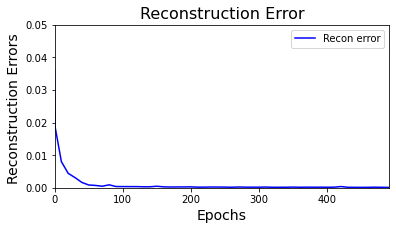

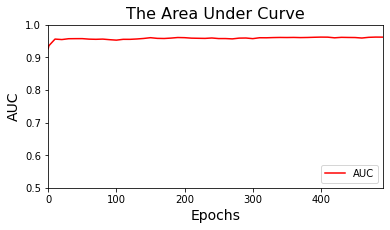

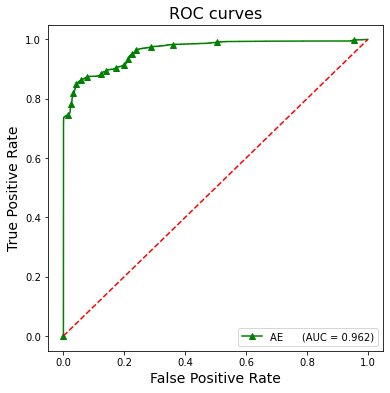

In [40]:
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)
num_batch = int(train_X.shape[0]/batch_size)


# Training
monitor = np.empty([0,3])    #Define a array to store training errors, and AUC during training process
for i in range(epochs):
    re_batch = 0
    for i_batch in range(num_batch):
        batch_x  = train_X[i_batch:i_batch+1] 
        _,l      = sess.run([optimizer, loss], feed_dict={X: batch_x})
        re_batch = re_batch + l
        
    # Display logs per step
    if i % display_step == 0 or i == 1:
        recon_X   = sess.run(Y, feed_dict={X:test_X_noise})
        _, _, auc = compute_AUC(recon_X, test_X, test_Y)

        re = re_batch/num_batch
        monitor = np.append(monitor,[i, re, auc])
        print('Step %3.0f: Loss: %f AUC: %0.4f' % (i, re, auc))
    
monitor = np.reshape(monitor, (-1,3))
#Draw RE and AUC during training process
Plotting_RE_AUC(monitor)

#Compute and draw ROC curve after training
recon_X   = sess.run(Y, feed_dict={X:test_X_noise})
FPR, TPR, auc = compute_AUC(recon_X, test_X, test_Y)
Plotting_AUC(FPR, TPR, auc)